In [199]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
# plt.style.use('ggplot')
# % matplotlib inline

In [200]:
df = pd.read_csv('CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related and informative          685
Related - but not informative    268
Not related                      238
Not applicable                     9
Name: Informativeness, dtype: int64

In [201]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related and informative          622
Related - but not informative    257
Not related                      238
Name: Informativeness, dtype: int64

In [202]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related,Not related or not informative
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related,Not related or not informative
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related,Not related or not informative
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related,Not related or not informative
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related,Not related or not informative


In [203]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import HashingVectorizer
import preprocessor as p

emoji_re = "['\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF']"
emojis = [regexp_tokenize(t, emoji_re) for t in df.TweetText]
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i] if t not in en_stop ]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related,Not related or not informative,#intern #us #tattoo #wisconsin #ohio #nc #pa #...
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related,Not related or not informative,rt @jack4ward : get fun every thursday @csinde...
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related,Not related or not informative,welcome newest studentathlete - reagan biechle...
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related,Not related or not informative,denver post : #colorado governor sign bill cre...
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related,Not related or not informative,"pretty sure i'm going live manitou spring , co..."


In [204]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
hash_pp_vec = HashingVectorizer(analyzer='word', non_negative=True)
X_hash_pp_train = hash_pp_vec.fit_transform(X_train2)  
X_hash_pp_test = hash_pp_vec.transform(X_test2)

D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


In [205]:
mnb_hash_pp = MultinomialNB(0.01, False)
mnb_hash_pp.fit(X_hash_pp_train, y_train2)

from sklearn.cross_validation import cross_val_score, KFold 
from scipy.stats import sem 

def evaluate_cross_validation(clf, X, y, K):
    cv = KFold(len(y), K, shuffle=True, random_state=0)  
    scores = cross_val_score(clf, X, y, cv=cv) 
    print scores
    print ("Mean score: {0:.4f} (+/-{1:.4f})").format(np.mean(scores), sem(scores))

evaluate_cross_validation(mnb_hash_pp, X_hash_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_hash_pp.score(X_hash_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_hash_pp.score(X_hash_pp_test, y_test2))

[0.78571429 0.85714286 0.72619048 0.9047619  0.8452381  0.72619048
 0.78571429 0.81927711 0.69879518 0.8313253 ]
Mean score: 0.7980 (+/-0.0209)
Accuracy for training: 0.986857825568
Accuracy for testing: 0.760714285714


In [206]:
y_hash_pp_predict = mnb_hash_pp.predict(X_hash_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_hash_pp_predict) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_hash_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative       0.87      0.60      0.71       137
       Related and informative       0.70      0.92      0.80       143

                   avg / total       0.79      0.76      0.75       280

Confusion Matrix:
[[ 82  55]
 [ 12 131]]


In [207]:
X_hash_pp_test.shape

(280, 1048576)

D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: Depreca

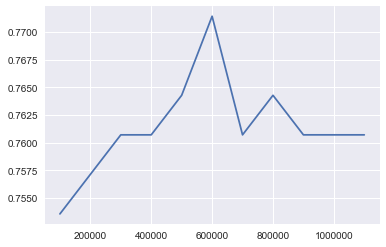

[0.7535714285714286, 0.7571428571428571, 0.7607142857142857, 0.7607142857142857, 0.7642857142857142, 0.7714285714285715, 0.7607142857142857, 0.7642857142857142, 0.7607142857142857, 0.7607142857142857, 0.7607142857142857]


In [208]:
k = range(100000,1200000,100000)
k_score = []
for i in k:  
    hash_pp_vec = HashingVectorizer(analyzer='word', n_features = i, non_negative=True)  
    X_hash_pp_train = hash_pp_vec.fit_transform(X_train2)
    X_hash_pp_test = hash_pp_vec.transform(X_test2)
    mnb_hash_pp = MultinomialNB(0.01, False)  
    mnb_hash_pp.fit(X_hash_pp_train, y_train2)
    score = mnb_hash_pp.score(X_hash_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

In [209]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related,Not related or not informative,#intern #us #tattoo #wisconsin #ohio #nc #pa #...
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related,Not related or not informative,rt @jack4ward : get in on the fun every thursd...
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related,Not related or not informative,welcome to our newest studentathlete - reagan ...
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related,Not related or not informative,denver post : #colorado governor sign bill cre...
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related,Not related or not informative,pretty sure i'm going to live in manitou sprin...


In [210]:
split_percentage = 0.25
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.ProcessedText, df.label, test_size=split_percentage, random_state=42) 
hash_pp_vec = HashingVectorizer(analyzer='word', non_negative=True)
X_hash_pp_train = hash_pp_vec.fit_transform(X_train2)  
X_hash_pp_test = hash_pp_vec.transform(X_test2)

D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


In [211]:
mnb_hash_pp = MultinomialNB(0.1, False)  
mnb_hash_pp.fit(X_hash_pp_train, y_train2)

evaluate_cross_validation(mnb_hash_pp, X_hash_pp_train, y_train2, 10)

print 'Accuracy for training: {}'.format(mnb_hash_pp.score(X_hash_pp_train, y_train2))
print 'Accuracy for testing: {}'.format(mnb_hash_pp.score(X_hash_pp_test, y_test2))

[0.78571429 0.85714286 0.73809524 0.8452381  0.85714286 0.72619048
 0.82142857 0.77108434 0.71084337 0.84337349]
Mean score: 0.7956 (+/-0.0179)
Accuracy for training: 0.972520908005
Accuracy for testing: 0.789285714286


In [212]:
y_hash_pp_predict = mnb_hash_pp.predict(X_hash_pp_test) 
print "Classification Report:" 
print metrics.classification_report(y_test2,y_hash_pp_predict) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(y_test2,y_hash_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative       0.93      0.61      0.74       137
       Related and informative       0.72      0.96      0.82       143

                   avg / total       0.82      0.79      0.78       280

Confusion Matrix:
[[ 84  53]
 [  6 137]]


In [213]:
X_hash_pp_test.shape

(280, 1048576)

D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: Depreca

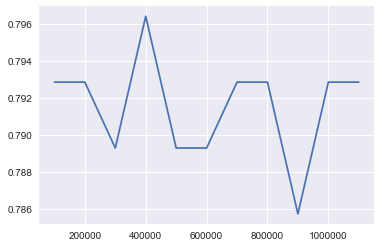

[0.7928571428571428, 0.7928571428571428, 0.7892857142857143, 0.7964285714285714, 0.7892857142857143, 0.7892857142857143, 0.7928571428571428, 0.7928571428571428, 0.7857142857142857, 0.7928571428571428, 0.7928571428571428]


In [214]:
k = range(100000,1200000,100000)
k_score = []
for i in k:  
    hash_pp_vec = HashingVectorizer(analyzer='word', n_features = i, non_negative=True)  
    X_hash_pp_train = hash_pp_vec.fit_transform(X_train2)
    X_hash_pp_test = hash_pp_vec.transform(X_test2)
    mnb_hash_pp = MultinomialNB(0.1, False)  
    mnb_hash_pp.fit(X_hash_pp_train, y_train2)
    score = mnb_hash_pp.score(X_hash_pp_test, y_test2) 
    k_score.append(score)  
plt.plot(k,k_score)  
plt.show()
print k_score

### Test other data set

### Colorado floods

In [215]:
df = pd.read_csv('CrisisLexT26/2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related and informative          768
Related - but not informative    157
Not related                       70
Not applicable                     5
Name: Informativeness, dtype: int64

In [216]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related and informative          691
Related - but not informative    156
Not related                       70
Name: Informativeness, dtype: int64

In [217]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,376843697943769088,#Longmont #CO The Tiny Tim Center is now #hiri...,Not labeled,Not labeled,Not related,Not related or not informative
1,378011169883037697,"RT @dlfluegge: Crazy Flooding in Boulder, Colo...",Media,Sympathy and support,Related - but not informative,Not related or not informative
2,378020179214491649,Here's the #boulderflood video that's circulat...,Outsiders,Other Useful Information,Related and informative,Related and informative
3,378026101588496385,RT @passantino: Video: Severe flooding hits ne...,Media,Other Useful Information,Related and informative,Related and informative
4,378029784204206080,"Crazy Flooding in Boulder, Colorado http://t.c...",Media,Other Useful Information,Related and informative,Related and informative


In [218]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,376843697943769088,#Longmont #CO The Tiny Tim Center is now #hiri...,Not labeled,Not labeled,Not related,Not related or not informative,#longmont #co the tiny tim center is now #hiri...
1,378011169883037697,"RT @dlfluegge: Crazy Flooding in Boulder, Colo...",Media,Sympathy and support,Related - but not informative,Not related or not informative,"rt @dlfluegge : crazy flooding in boulder , co..."
2,378020179214491649,Here's the #boulderflood video that's circulat...,Outsiders,Other Useful Information,Related and informative,Related and informative,here's the #boulderflood video that's circulat...
3,378026101588496385,RT @passantino: Video: Severe flooding hits ne...,Media,Other Useful Information,Related and informative,Related and informative,rt @passantino : video : severe flooding hit n...
4,378029784204206080,"Crazy Flooding in Boulder, Colorado http://t.c...",Media,Other Useful Information,Related and informative,Related and informative,"crazy flooding in boulder , colorado"


In [219]:
X_hash_pp_test = hash_pp_vec.transform(df.ProcessedText)

y_hash_pp_predict = mnb_hash_pp.predict(X_hash_pp_test)

print "Classification Report:" 
print metrics.classification_report(df.label,y_hash_pp_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(df.label,y_hash_pp_predict)
print "Accuracy:"
print metrics.accuracy_score(df.label,y_hash_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.5095    0.4735    0.4908       226
       Related and informative     0.8317    0.8509    0.8412       691

                   avg / total     0.7523    0.7579    0.7548       917

Confusion Matrix:
[[107 119]
 [103 588]]
Accuracy:
0.7579062159214831


D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


### Australia fire

In [220]:
df = pd.read_csv('CrisisLexT26/2013_Australia_bushfire/2013_Australia_bushfire-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related and informative          704
Related - but not informative    245
Not related                      242
Not applicable                     8
Name: Informativeness, dtype: int64

In [221]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related and informative          602
Not related                      242
Related - but not informative    235
Name: Informativeness, dtype: int64

In [222]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,388923108922781697,"It's ridiculous,,,RT @ThatGuyTiisetso: #redoct...",Not labeled,Not labeled,Not related,Not related or not informative
1,388929052247347200,A Total Fire Ban has been declared for the Gre...,Media,Caution and advice,Related and informative,Related and informative
2,388970580026089472,This #RedOctober shit is just the beginning of...,Not labeled,Not labeled,Not related,Not related or not informative
3,388972203242704896,You can't be supporting #RedOctober mr white m...,Not labeled,Not labeled,Not related,Not related or not informative
4,388986124107927553,RT @smh: Do not light fires in the open: RFS w...,Media,Caution and advice,Related and informative,Related and informative


In [223]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,388923108922781697,"It's ridiculous,,,RT @ThatGuyTiisetso: #redoct...",Not labeled,Not labeled,Not related,Not related or not informative,"it's ridiculous , , , rt @thatguytiisetso : #r..."
1,388929052247347200,A Total Fire Ban has been declared for the Gre...,Media,Caution and advice,Related and informative,Related and informative,a total fire ban ha been declared for the grea...
2,388970580026089472,This #RedOctober shit is just the beginning of...,Not labeled,Not labeled,Not related,Not related or not informative,this #redoctober shit is just the beginning of...
3,388972203242704896,You can't be supporting #RedOctober mr white m...,Not labeled,Not labeled,Not related,Not related or not informative,you can't be supporting #redoctober mr white m...
4,388986124107927553,RT @smh: Do not light fires in the open: RFS w...,Media,Caution and advice,Related and informative,Related and informative,rt @smh : do not light fire in the open : rf w...


In [224]:
X_hash_pp_test = hash_pp_vec.transform(df.ProcessedText)

y_hash_pp_predict = mnb_hash_pp.predict(X_hash_pp_test)

print "Classification Report:" 
print metrics.classification_report(df.label,y_hash_pp_predict, digits=4)  
print "Confusion Matrix:" 
print metrics.confusion_matrix(df.label,y_hash_pp_predict)
print "Accuracy:"
print metrics.accuracy_score(df.label,y_hash_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.7538    0.5136    0.6110       477
       Related and informative     0.6923    0.8671    0.7699       602

                   avg / total     0.7195    0.7108    0.6996      1079

Confusion Matrix:
[[245 232]
 [ 80 522]]
Accuracy:
0.7108433734939759


D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


### Australia flood

In [225]:
df = pd.read_csv('CrisisLexT26/2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv') # change the file location if needed

col_dict = {}
for old_feature in df.columns.values:
    col_dict.update({old_feature: old_feature.replace(' ','')})
df.rename(columns=col_dict, inplace=True)

df.Informativeness.value_counts()

Related and informative          728
Not related                      261
Related - but not informative    191
Not applicable                    20
Name: Informativeness, dtype: int64

In [226]:
df = df[df.InformationSource != 'Government']
df = df[df.Informativeness!='Not applicable'].reset_index(drop=True)
df.Informativeness.value_counts()

Related and informative          665
Not related                      261
Related - but not informative    186
Name: Informativeness, dtype: int64

In [227]:
label = ['Not related or not informative'] * df.shape[0]
idx = df.index[df.Informativeness == 'Related and informative'].tolist()
for i in idx: label[i] = 'Related and informative'
df['label'] = pd.Series(label)

df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label
0,291852896990023680,RT @AdmireAriana: Heat wave in Australia. Floo...,Not labeled,Not labeled,Not related,Not related or not informative
1,291853232538537984,RT @AdmireAriana: Heat wave in Australia. Floo...,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative
2,291921947787395072,Jakarta floods leave hundreds of thousands hom...,Media,Not applicable,Related and informative,Related and informative
3,292248541500420096,"Bush fires in Australia, deadly flooding in In...",Outsiders,Other Useful Information,Related and informative,Related and informative
4,293071229055799297,VIDEO - A world of contrasts. We freeze whilst...,Outsiders,Affected individuals,Related - but not informative,Not related or not informative


In [228]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
all_tweets = [p.clean(t).lower() for t in df.TweetText]

tknzr = TweetTokenizer()
all_tokens = [tknzr.tokenize(t) for t in all_tweets]
#en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
processed_texts = []  # preprocessed tweets

for i in range(len(all_tokens)):
    processed_texts.append(' '.join([lemmatizer.lemmatize(t) for t in all_tokens[i]]))

df['ProcessedText'] = pd.Series(processed_texts)
df.head()

,TweetID,TweetText,InformationSource,InformationType,Informativeness,label,ProcessedText
0,291852896990023680,RT @AdmireAriana: Heat wave in Australia. Floo...,Not labeled,Not labeled,Not related,Not related or not informative,rt @admireariana : heat wave in australia . fl...
1,291853232538537984,RT @AdmireAriana: Heat wave in Australia. Floo...,Outsiders,Other Useful Information,Related - but not informative,Not related or not informative,rt @admireariana : heat wave in australia . fl...
2,291921947787395072,Jakarta floods leave hundreds of thousands hom...,Media,Not applicable,Related and informative,Related and informative,jakarta flood leave hundred of thousand homele...
3,292248541500420096,"Bush fires in Australia, deadly flooding in In...",Outsiders,Other Useful Information,Related and informative,Related and informative,"bush fire in australia , deadly flooding in in..."
4,293071229055799297,VIDEO - A world of contrasts. We freeze whilst...,Outsiders,Affected individuals,Related - but not informative,Not related or not informative,video - a world of contrast . we freeze whilst...


In [229]:
X_hash_pp_test = hash_pp_vec.transform(df.ProcessedText)

y_hash_pp_predict = mnb_hash_pp.predict(X_hash_pp_test)

print "Classification Report:" 
print metrics.classification_report(df.label,y_hash_pp_predict, digits=4) 
print "Confusion Matrix:" 
print metrics.confusion_matrix(df.label,y_hash_pp_predict)
print "Accuracy:"
print metrics.accuracy_score(df.label,y_hash_pp_predict)

Classification Report:
                                precision    recall  f1-score   support

Not related or not informative     0.6712    0.6622    0.6667       447
       Related and informative     0.7750    0.7820    0.7784       665

                   avg / total     0.7333    0.7338    0.7335      1112

Confusion Matrix:
[[296 151]
 [145 520]]
Accuracy:
0.7338129496402878


D:\Anaconda2\lib\site-packages\sklearn\feature_extraction\hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


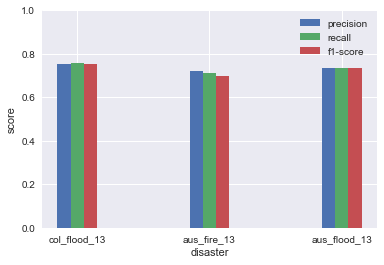

In [230]:
import seaborn as sns

sns.set()
plt.bar([0.9,1.9,2.9], [0.7523,0.7195,0.7333], width=0.1, label='precision')
plt.bar([1,2,3], [0.7579,0.7108,0.7338], width=0.1, label='recall')
plt.bar([1.1,2.1,3.1], [0.7548,0.6996,0.7335], width=0.1, label='f1-score')
plt.xticks([1,2,3], ['col_flood_13', 'aus_fire_13', 'aus_flood_13'])
plt.ylim([0,1])
plt.legend(loc='best')
plt.xlabel('disaster')
plt.ylabel('score')
plt.show()